# Implementation of Spam Classifier by simple RNN model



In order to get a better understanding of RNN we'll try to understand it with an example , here we are going to build a simple RNN model that classifies message into SPAM or HAM

---



---



---

I have implemented my code on google colab notebook

In [ ]:
#importing drive 
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#importing pandas for reading csv file from drive
import pandas as pd


In [ ]:
training_data= pd.read_csv("/content/drive/My Drive/SMSCollection.txt",sep='\t',names=['label','text'])

In [ ]:

training_data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


This is how are data looks.

In [ ]:
#checking the shape of dataset
training_data.shape

(5572, 2)

In [ ]:
import re
import string

This is a function to clean text withe the help of re or Regular expression library (*A regular expression is a special sequence of characters that helps you match or find other strings or sets of strings, using a specialized syntax held in a pattern*) re,sub removes the special characters and urls from the text

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
training_data['text'] = training_data['text'].apply(lambda x: clean_text(x))

Label Encoding the labels in the dataset **Ham:0, Spam:1**


In [ ]:
from sklearn.preprocessing import LabelEncoder
lb= LabelEncoder()

In [ ]:
training_data['label'] = lb.fit_transform(training_data['label'])

Our modified dataset looks like this..

In [ ]:
training_data.head()

,label,text
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in a wkly comp to win fa cup final...
3,0,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives aroun...


Now we'll convert our modified dataset into CSV file

In [ ]:

training_data.to_csv('train.csv', index=False)

# Getting started with Pytorch


**Importing Necessary Pytorch libraries for dealing with text data**

* Torch package is used to define tensors and mathematical operations on it
* TorchText is a Natural Language Processing (NLP) library in PyTorch. This     library contains the scripts for preprocessing text and source of few popular   NLP datasets.





In [ ]:
import torch
import torchtext
from torchtext import data 
import os

Setting device to GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing data in Pytorch

---

torchtext.data provides a **Field** object which use to preprocess data,Every dataset consists of one or more types of data. For instance, a text classification dataset contains sentences and their classes(labels)
*`Field class models common text processing datatypes that can be represented by tensors. It holds a Vocab object that defines the set of possible values for elements of the field and their corresponding numerical representations. The Field object also holds other parameters relating to how a datatype should be numericalized, such as a tokenization method and the kind of Tensor that should be produced`*


---



---

Here we'll define 
* TEXT field with parametrs as tokenizer,(spacy since it uses novel tokenization algorithm), batch_first keeps the first dimension of input and output as batch size
* LabelField : converts the label into torch tensor float.


**Thus our dataset will have 2 columns as label and text**


In [ ]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)
fields = [('label', LABEL), ('text',TEXT)]

TabularDataset is used to load a custom data set it takes path of csv file as a input, fields are the list of tuples defining text and label

In [ ]:
#loading custom dataset
training_data=data.TabularDataset(path = 'train.csv',format = 'csv',fields = fields,skip_header = True)

#print preprocessed text
print(vars(training_data.examples[0]))

{'label': '0', 'text': ['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']}


In [ ]:
#seeding our program
SEED= 42
torch.manual_seed(SEED)

splitting the dataset into training and validation dataset

In [ ]:
import random
train_data, valid_data = training_data.split(split_ratio=0.7, random_state = random.seed(SEED))

The next step is to build the vocabulary for the text and convert them into integer sequences. **Vocabulary contains the unique words in the entire text. Each unique word is assigned an index**.  build_vocab function construct the Vocab object for this field from the dataset.
We are building vocabulary with pre trained glove embeddings
Two special tokens known as unknown and padding will be added to the vocabulary
* Unknown token is used to handle Out Of Vocabulary words
* Padding token is used to make input sequences of same length

In [ ]:
#initialize glove embeddings
TEXT.build_vocab(train_data,min_freq=3,vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)

.vector_cache/glove.6B.zip: 862MB [06:26, 2.23MB/s]                           
 99%|█████████▉| 397703/400000 [00:17<00:00, 23091.78it/s]

Size of TEXT vocabulary: 2070
Size of LABEL vocabulary: 2
[(' ', 2704), ('i', 1995), ('to', 1609), ('you', 1556), ('a', 1032), ('the', 929), ('u', 766), ('and', 671), ('is', 648), ('in', 606)]
defaultdict(<function _default_unk_index at 0x7f37af8b4840>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'i': 3, 'to': 4, 'you': 5, 'a': 6, 'the': 7, 'u': 8, 'and': 9, 'is': 10, 'in': 11, 'me': 12, 'for': 13, 'my': 14, 'your': 15, 'do': 16, 'nt': 17, 'have': 18, 'it': 19, 'of': 20, 'that': 21, 'call': 22, 'on': 23, 'are': 24, 'm': 25, 'now': 26, 'not': 27, 'so': 28, 'or': 29, 'but': 30, 'can': 31, 'at': 32, 'ur': 33, 'will': 34, 'get': 35, 'be': 36, 'just': 37, 'with': 38, 'if': 39, 'we': 40, 'no': 41, 'this': 42, '£': 43, 'its': 44, 's': 45, 'how': 46, 'free': 47, 'when': 48, 'go': 49, 'what': 50, 'ok': 51, 'up': 52, 'all': 53, '  ': 54, 'from': 55, 'know': 56, 'out': 57, 'got': 58, 'ltgt': 59, 'ill': 60, 'like': 61, 'there': 62, 'come': 63, 'was': 64, 'am': 65, 'good': 66, 'then': 67, 'love': 68, 'he': 69

**Preparing  batches for training the mode using BucketIterator**
 It defines an iterator that batches examples of similar lengths together.
Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch. 

In [ ]:
BATCH_SIZE = 64

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [ ]:
print(vars(valid_data.examples[0]))

{'label': '0', 'text': ['alex', 'says', 'he', 's', 'not', 'ok', 'with', 'you', 'not', 'being', 'ok', 'with', 'it']}


# Model Architecture
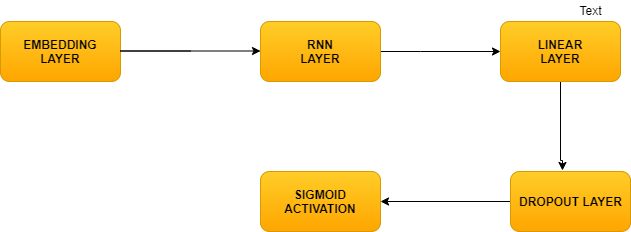

The above shown picture is our model architecture, here we are defining a class ClassifierModel which is a subclass of nn.Module class which is Base class for all neural network modules.
 It will have two functions init function, and forward function
* INIT function : it contains the constructor of the class it will initialises the componnent of the class. Whenever an instance of a class is created, init function is automatically invoked. Hence, it is called as a constructor.
* Forward function:- Forward function defines the forward pass of the inputs.


---


**COMPONENTS OF MODEL **

1. **Embedding layer**:- In embedding layer embeddings individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network. *Key to the approach is the idea of using a dense distributed representation for each word.*. It takes 2 input  
    1.   Input dimension:- number of unique words in the vocabulary
    2.   Embedding dimension:- length in which vector of each word embedding is represented

2. **RNN layer**:- It is a Rnn which reads the word sequence . It takes the following input parameters:-
    1. embedding_dim - length of each embedding vector or input sequence
    2. Hidden_dim- it defines the number of hidden nodes in RNN
    3. num_layers - Number of RNN layers to be stacked

3. **Linear layer**- or dense layer, it takes two input 

    1. hidden_ dim= number of input feature
    2. output_dim=  number of output feature

4.   **Pack padding sequences**:- pytorch allows us to pack the sequence, internally packed sequence is a tuple of two lists. One contains the elements of sequences. Elements are interleaved by time steps (see example below) and other containsthe batch size at each step. This is helpful in recovering the actual sequences as well as telling RNN what is the batch size at each time step.  



In [ ]:
 
import torch.nn as nn
import torch.nn.functional as F
class ClassifierModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim,num_layers=2)
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(0.2)
        self.act= nn.Sigmoid()

    def forward(self, text,text_lengths):
        # text [sentence length, batch_size]

        embedded = self.embedding(text)
        
        #packed sequence
        text_lengths_clamped = text_lengths.clamp(min=1, max=100)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths_clamped,batch_first=True)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
                
        output = self.fc1(hidden)
        output = self.dropout(output)
        output= self.act(output)
        return output

Initialising parameters

In [ ]:
input_dim = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 1

#instantiate the model
model = ClassifierModel(input_dim, embedding_dim, num_hidden_nodes,num_output_nodes)

Visualising the model

In [ ]:

#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')


ClassifierModel(
  (embedding): Embedding(2070, 100)
  (rnn): RNN(100, 32, num_layers=2)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (act): Sigmoid()
)
The model has 213,433 trainable parameters


Initialising the embedding layer with pretrained embeddings

In [ ]:
#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)


print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.6663,  0.0492,  0.2599,  ..., -0.6937,  0.0191, -0.0656],
        [-0.1554,  0.3377, -0.2220,  ..., -0.8515, -0.3765,  0.0668],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


Defining optimizer and loss function fo training:- 

Optimizer is adam optimizer
and loss is BCEwithLogit loss for binary classification

In [ ]:
import torch.optim as optim
EPOCHS= 10
#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

# Training and Evaluating Function

In [ ]:
def train_epoch(model,iterator,criterion,optimizer,device, n_examples):
    model= model.train()
    losses = []
    for  batch in iterator:
        #retrieve text and no. of words
        text, text_lengths = batch.text 
        outputs = model(text,text_lengths).squeeze(1)
        loss = criterion(outputs, batch.label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return np.mean(losses)


In [ ]:
def eval_model(model, iterator, criterion, device, n_examples):
    
    model = model.eval()
    losses = []
    with torch.no_grad():
        for  batch in iterator:
           text, text_lengths = batch.text
           outputs = model(text,text_lengths).squeeze(1)
           loss = criterion(outputs, batch.label)
           losses.append(loss.item())
      
        return np.mean(losses)

In [ ]:
from collections import defaultdict
import numpy as np


Printing the loss for each epoch

In [ ]:

history = defaultdict(list)
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_loss = train_epoch(model,train_iterator,criterion,optimizer,device,len(train_iterator))
    print(f'Train loss {train_loss}')
    val_loss = eval_model(model,valid_iterator,criterion,device,len(valid_iterator))
    print(f'Val   loss {val_loss} ')
    print()
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)


Epoch 1/10
----------
Train loss 0.7738257714959441
Val   loss 0.7100893612261172 

Epoch 2/10
----------
Train loss 0.7375994441939182
Val   loss 0.702339752956673 

Epoch 3/10
----------
Train loss 0.736222930618974
Val   loss 0.6978233191702101 

Epoch 4/10
----------
Train loss 0.7296022313540099
Val   loss 0.6861234616350245 

Epoch 5/10
----------
Train loss 0.7152435242152605
Val   loss 0.6677590409914652 

Epoch 6/10
----------
Train loss 0.7067380742948564
Val   loss 0.6710451730975399 

Epoch 7/10
----------
Train loss 0.7031934456747087
Val   loss 0.664336849142004 

Epoch 8/10
----------
Train loss 0.702530002007719
Val   loss 0.6618876501365945 

Epoch 9/10
----------
Train loss 0.6998005636402818
Val   loss 0.6634305185741849 

Epoch 10/10
----------
Train loss 0.7040034161239374
Val   loss 0.6628757030875595 



# Prediction on a random 
Firstly we have to put the model at Evaluation mode.

We'll define a function nmaed predict which will take up an input sentence and will predict wether the sentence is a spam mail or ham mail,

The compnent of the functions are :
1. It takes up the text and clean it (remove special characters etc)
2. then it tokenize the sentence
3. Then it converts the tokenized sequence into a tensor
4. and then it calculates the length of tense
5. It passes both sequence of integers and length to model 
6. we take the maximum of the result and produce the prediction


In [ ]:
model.eval()
import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    sentence= clean_text(sentence)
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction 
    preds= torch.max(prediction)
    if (preds>0.005):
      result= 'spam!!'
    else:
      result= 'ham!'


    return result

In [ ]:
predict(model, "Are you okay")

'ham!'

In [ ]:
predict(model,"Free massage coupons")

'spam!!'